# Task 3: Build a Neural Network

## Library

In [2]:
# Import Library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Attention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
from datetime import datetime

## Load Data

In [3]:
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

data_path = os.path.join(DATA_DIR, "Stock Prices Data Set.csv")
data = pd.read_csv(data_path)

In [4]:
print("Stock Prices Data Shape:", data.shape)

Stock Prices Data Shape: (497472, 7)


In [5]:
print("Stock Prices Data Preview:")
display(data.head())

Stock Prices Data Preview:


,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


## Preprocessing

In [6]:
# Convert and sort by date
data["date"] = pd.to_datetime(data["date"])
data.sort_values(by=["symbol", "date"], inplace=True)

In [7]:
# Remove duplicates if any
data.drop_duplicates(subset=["symbol", "date"], inplace=True)

In [8]:
# Take the Top-N most frequently occurring symbol
top_symbols = data['symbol'].value_counts().nlargest(10).index
data = data[data['symbol'].isin(top_symbols)]

In [9]:
# Encode target label
label_encoder = LabelEncoder()
data["symbol_encoded"] = label_encoder.fit_transform(data["symbol"])

In [10]:
# Define features and target
features = ["open", "high", "low", "close", "volume"]
target = "symbol_encoded"

In [11]:
# Remove rows with missing or zero volume (if any)
data = data.dropna(subset=features)
data = data[data["volume"] > 0]

In [12]:
# Normalize features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [13]:
# Drop rows with NaN or inf after normalization
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

In [14]:
# Create sequences per stock symbol
def create_symbol_sequences(df, time_steps=30):
    X, y = [], []
    symbols = df["symbol"].unique()
    for symbol in symbols:
        temp = df[df["symbol"] == symbol]
        values = temp[features].values.astype(np.float32)
        labels = temp[target].values
        if len(values) <= time_steps:
            continue
        for i in range(len(values) - time_steps):
            X.append(values[i:i+time_steps])
            y.append(labels[i+time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 30
X_seq, y_seq = create_symbol_sequences(data, time_steps=TIME_STEPS)

In [15]:
print(f"Total sequences created: {X_seq.shape[0]}")

Total sequences created: 9770


In [16]:
print(f"Input shape: {X_seq.shape}, Output shape: {y_seq.shape}")

Input shape: (9770, 30, 5), Output shape: (9770,)


## One Hot Encoding for Targets

In [17]:
# One Hot Encoding for Targets
y_seq_cat = to_categorical(y_seq)

## Split dataset

In [18]:
# Split dataset
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X_seq, y_seq_cat, test_size=0.2, random_state=42, stratify=y_seq
)

## Compute class weights

In [19]:
# Compute class weights
y_integers = np.argmax(y_train_cat, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weights = dict(enumerate(class_weights))

## Build Neural Network Model

In [20]:
# Build Neural Network Model with Attention
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

attention = Attention()([x, x])
x = GlobalAveragePooling1D()(attention)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
output = Dense(y_train_cat.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Callbacks (use .h5 to avoid errors)
now = datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = f"best_model_{now}.h5"
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

## Train Model

In [22]:
# Train Model
history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
244/245 [============================>.] - ETA: 0s - loss: 1.2422 - accuracy: 0.5666
Epoch 1: val_accuracy improved from -inf to 0.12180, saving model to best_model_20250407-104051.h5
245/245 [==============================] - 18s 51ms/step - loss: 1.2422 - accuracy: 0.5664 - val_loss: 3.1402 - val_accuracy: 0.1218 - lr: 0.0010
Epoch 2/100
  3/245 [..............................] - ETA: 9s - loss: 1.1894 - accuracy: 0.5625 

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


244/245 [============================>.] - ETA: 0s - loss: 0.9967 - accuracy: 0.6367
Epoch 2: val_accuracy improved from 0.12180 to 0.39304, saving model to best_model_20250407-104051.h5
245/245 [==============================] - 10s 42ms/step - loss: 0.9975 - accuracy: 0.6365 - val_loss: 1.8622 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 3/100
244/245 [============================>.] - ETA: 0s - loss: 0.9198 - accuracy: 0.6580
Epoch 3: val_accuracy improved from 0.39304 to 0.49744, saving model to best_model_20250407-104051.h5
245/245 [==============================] - 10s 42ms/step - loss: 0.9218 - accuracy: 0.6575 - val_loss: 1.3333 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 4/100
245/245 [==============================] - ETA: 0s - loss: 0.9089 - accuracy: 0.6594
Epoch 4: val_accuracy improved from 0.49744 to 0.62590, saving model to best_model_20250407-104051.h5
245/245 [==============================] - 10s 43ms/step - loss: 0.9089 - accuracy: 0.6594 - val_loss: 1.0692 - val_accurac

## Evaluate Model

In [23]:
# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9217


## Classification Report

In [24]:
# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

62/62 [==============================] - 2s 14ms/step

Classification Report:
              precision    recall  f1-score   support

           A       0.80      0.56      0.66       195
         MYL       0.99      0.98      0.98       195
        NFLX       1.00      0.99      1.00       195
         NFX       0.92      0.95      0.94       196
          NI       0.91      0.89      0.90       196
         NKE       0.99      1.00      1.00       195
        NLSN       0.69      0.88      0.77       196
         NOC       1.00      1.00      1.00       195
         NOV       0.95      0.96      0.96       195
         NRG       0.99      0.99      0.99       196

    accuracy                           0.92      1954
   macro avg       0.92      0.92      0.92      1954
weighted avg       0.92      0.92      0.92      1954



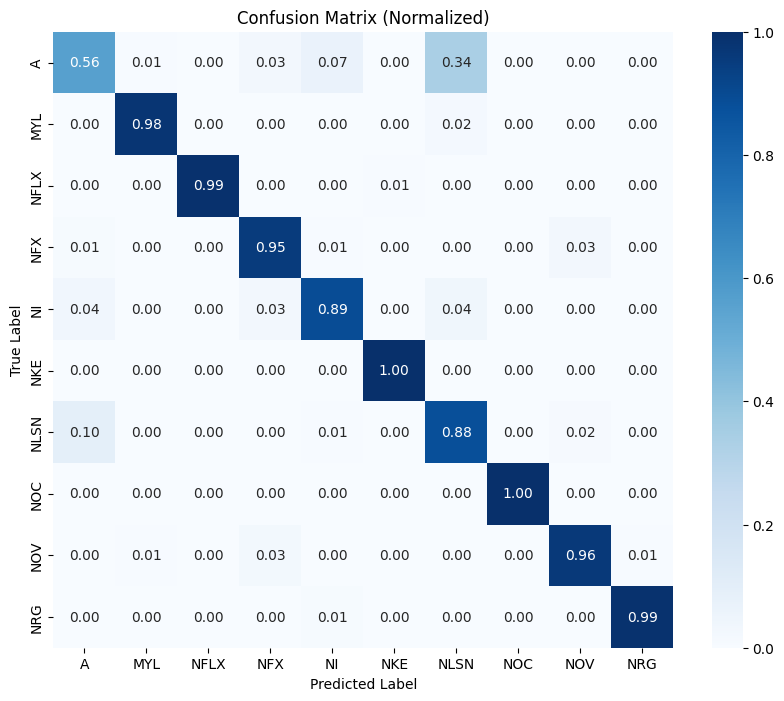

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.show()

## Plot Training History

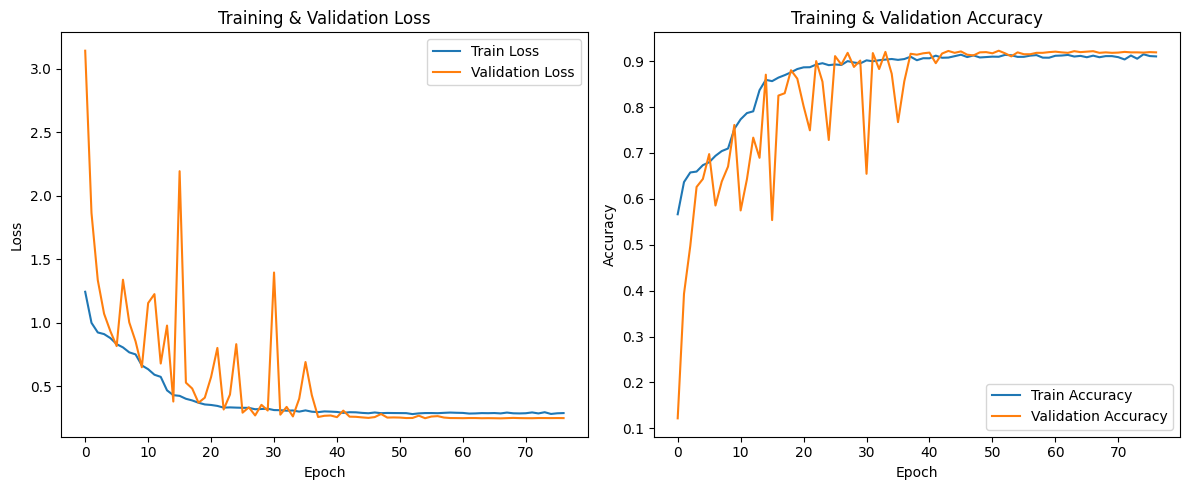

In [26]:
# Plot Training History
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Predict on New / Specific Data

In [27]:
# Choose one symbol for testing, for example AAPL
test_symbol = 'AAPL'
test_df = data[data["symbol"] == test_symbol].copy()

In [28]:
# Take the last 30 rows for that symbol
recent_data = test_df[-TIME_STEPS:]
if len(recent_data) < TIME_STEPS:
    print(f"Not enough data for symbol {test_symbol}")
else:
    test_sequence = recent_data[features].values.astype(np.float32)
    test_sequence = np.expand_dims(test_sequence, axis=0)  # shape: (1, 30, 5)

    # Predict
    prediction = model.predict(test_sequence)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"True Symbol: {test_symbol}")
    print(f"Predicted Symbol: {predicted_label}")

Not enough data for symbol AAPL


In [29]:
# Predict for all available symbols and plot results
symbols_to_test = data['symbol'].unique()
pred_results = []

for sym in symbols_to_test:
    test_df = data[data["symbol"] == sym].copy()
    recent_data = test_df[-TIME_STEPS:]
    if len(recent_data) < TIME_STEPS:
        continue
    test_sequence = recent_data[features].values.astype(np.float32)
    test_sequence = np.expand_dims(test_sequence, axis=0)

    prediction = model.predict(test_sequence)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    pred_results.append((sym, predicted_label))

1/1 [==============================] - 0s 22ms/step


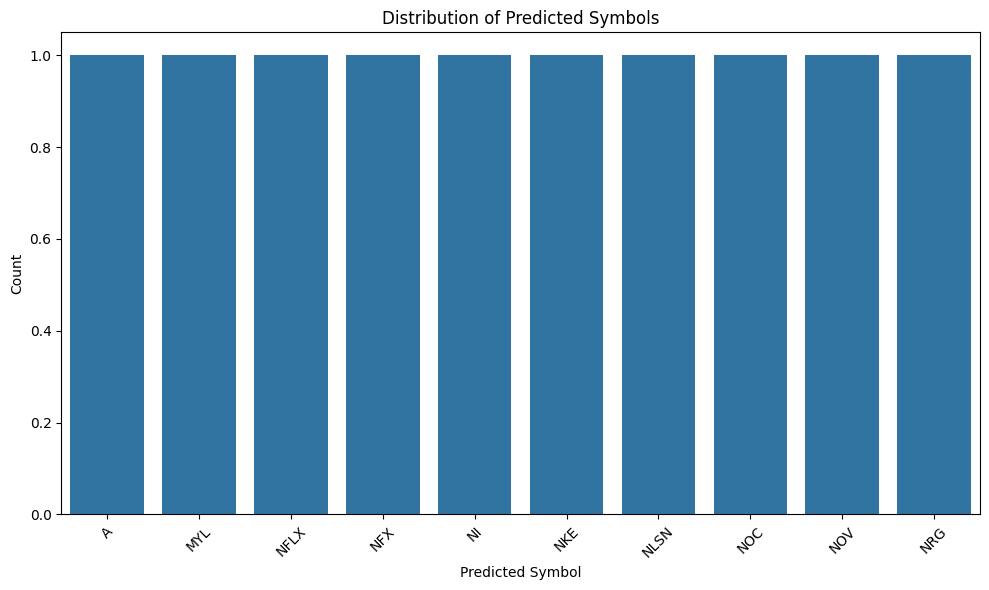

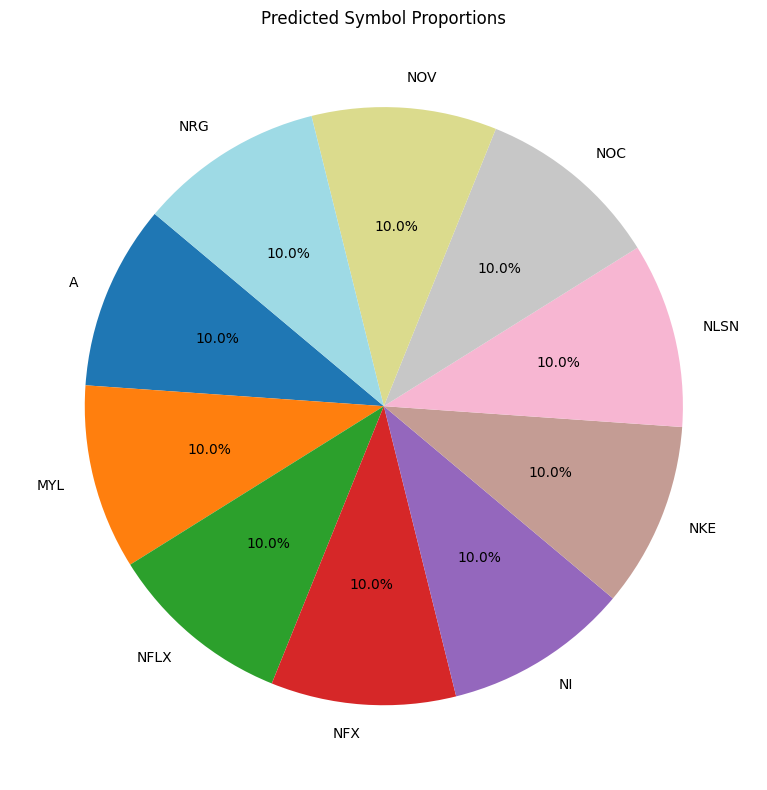

In [30]:
# Convert to DataFrame and plot
pred_df = pd.DataFrame(pred_results, columns=["True Symbol", "Predicted Symbol"])
pred_counts = pred_df.groupby("Predicted Symbol").size().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=pred_counts.index, y=pred_counts.values)
plt.title("Distribution of Predicted Symbols")
plt.xlabel("Predicted Symbol")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show pie chart
plt.figure(figsize=(8, 8))
pred_counts.plot.pie(autopct="%1.1f%%", startangle=140, colormap='tab20')
plt.title("Predicted Symbol Proportions")
plt.ylabel("")
plt.tight_layout()
plt.show()
